In [115]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
from parse import *
from config import api_key
import nasdaqdatalink
import scipy.stats as stats
from statistics import mean

In [116]:
# Load key for Nasdaq API
nasdaqdatalink.ApiConfig.api_key = api_key

# Load .csv with 'Forbes 100 preferered employer ranking'; 'Glassdoor score'; 'Nasdaq/Mergent' codes
forbes_source = pd.read_csv("resources/employers_clean.csv")

# Format .csv file
forbes_data_clean_df = forbes_source.dropna(subset=['mergent_ticker']).astype({'mergent_compnumber' : 'int64'})


In [117]:
# Parameters for Nasdaq query: list of insustrial sectors and financial metrics
mic_extract = forbes_data_clean_df['mergent_mic'].unique()
forbes_mics_forquery = list(mic_extract)
mapcode = [
    '-5011', # Return on Equity: (Net Income / Average Stockholders' Equity Over Period) * 100
    '-4023'] # EPS – Net Income – Diluted

# Run API : fetch universe of companies in the same sector as ranked Forbes companies
industry_data_filtered = nasdaqdatalink.get_table('MER/F1', mic=forbes_mics_forquery, mapcode=mapcode, reportdate='2021-12-31', reporttype='A')

# Prepare empty lists for Nasdaq industry data
compnumber_list = []
ticker_list = []
currency_list = []
mic_list = []
roe_list = []
eps_list = []

# Build Nasdaq industry data
for index, row in industry_data_filtered.iterrows():
    if industry_data_filtered.loc[index, 'mapcode'] == -5011:
        cn = industry_data_filtered.loc[index, 'compnumber']
        tk = industry_data_filtered.loc[index, 'ticker']
        cl = industry_data_filtered.loc[index, 'currency']
        mc = industry_data_filtered.loc[index, 'mic']
        rt = industry_data_filtered.loc[index, 'amount']
        compnumber_list.append(cn)
        ticker_list.append(tk)
        currency_list.append(cl)
        mic_list.append(mc)
        roe_list.append(rt)

industry_data_build = {
    'comp_number' : compnumber_list, 
    'ticker' : ticker_list,
    'currency' : currency_list,
    'sector' : mic_list,
    'ROE' : roe_list}

industry_data_build_df = pd.DataFrame(industry_data_build)
industry_data_trimmed_df = industry_data_build_df.loc[(industry_data_build_df["ROE"]>-400) & (industry_data_build_df["ROE"]<400)]


In [118]:
# Create column for industrial sectors summarised one level up in Forbes ranking
forbes_mics_shortlist = []
sector_col = []
for index, row in forbes_data_clean_df.iterrows():
    sector_col = forbes_data_clean_df.loc[index, 'mergent_mic']
    x = sector_col.split(".")
    forbes_mics_shortlist.append(f"{x[0]}.{x[1]}")
forbes_data_clean_df["sector_short"]= list(forbes_mics_shortlist)


In [119]:
# Create column for industrial sectors summarised one level up in Industy Data df
sector_mics_shortlist =[]
for index, row in industry_data_trimmed_df.iterrows():
    mic = industry_data_trimmed_df.loc[index, 'sector']
    sector_mics_shortlist.append(f"{mic.split('.')[0]}.{mic.split('.')[1]}")
industry_data_trimmed_df["sector_short"]= list(sector_mics_shortlist)


/Users/javiergausachs/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [120]:
# List of industrial sectors that apply to the Forbes ranked companies
selected_mic = list(set(forbes_data_clean_df["sector_short"]))


In [121]:
# Add ROE column to ranked_cos df
stripped_sectors_roes = industry_data_trimmed_df.loc[:, ["comp_number", "ROE"]]
forbes_data_wroes_df  = forbes_data_clean_df.merge(stripped_sectors_roes, left_on=str("mergent_compnumber"), right_on=str("comp_number"))

# Group Forbes ranked companies with ROE by sector
forbes_data_wroes_grouped = forbes_data_wroes_df.groupby(["sector_short"]).mean()


In [122]:
mic_names = pd.read_csv("resources/mergent_mic-codes.csv").drop(columns="MIC").dropna()


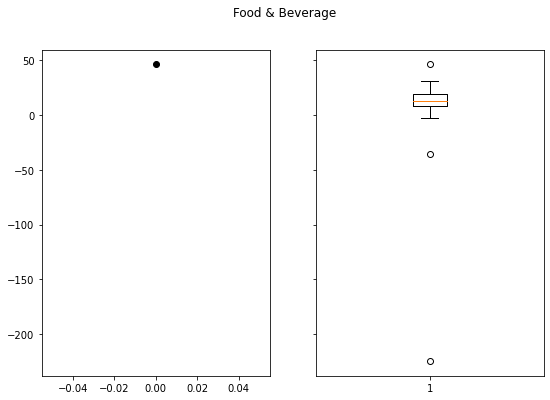

Industrial sector 'Food & Beverage' is comprised of the following 1 company(ies):
['Coca-Cola Co (The)']
----------
The lower quartile of ROE is: 46.200766
The upper quartile of ROE is: 46.200766
The interquartile range of ROE is: 0.0
The the median of ROE is: 46.200766 
Values below 46.200766 could be outliers.
Values above 46.200766 could be outliers.
----------
Peer sector comprised of 29 companies
----------
The lower quartile of ROE is: 7.895579
The upper quartile of ROE is: 19.048945
The interquartile range of ROE is: 11.153366
The the median of ROE is: 13.039099 
Values below -8.834470000000001 could be outliers.
Values above 35.778994 could be outliers.
----------


<Figure size 432x288 with 0 Axes>

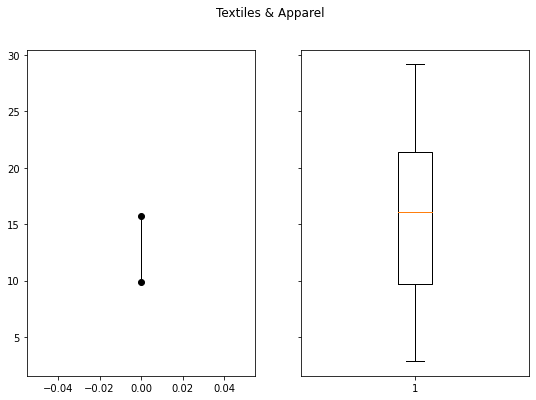

Industrial sector 'Textiles & Apparel' is comprised of the following 2 company(ies):
['Puma SE', 'Prada Spa']
----------
The lower quartile of ROE is: 11.356446
The upper quartile of ROE is: 14.274086
The interquartile range of ROE is: 2.9176400000000005
The the median of ROE is: 12.815266000000001 
Values below 6.979985999999999 could be outliers.
Values above 18.650546000000002 could be outliers.
----------
Peer sector comprised of 16 companies
----------
The lower quartile of ROE is: 9.693115500000001
The upper quartile of ROE is: 21.377422000000003
The interquartile range of ROE is: 11.684306500000002
The the median of ROE is: 16.045298000000003 
Values below -7.83334425 could be outliers.
Values above 38.903881750000004 could be outliers.
----------


<Figure size 432x288 with 0 Axes>

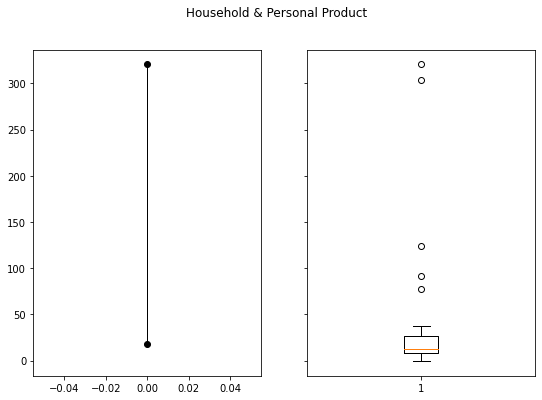

Industrial sector 'Household & Personal Product' is comprised of the following 2 company(ies):
['Colgate-Palmolive Co.', "L'Oreal S.A."]
----------
The lower quartile of ROE is: 93.218462
The upper quartile of ROE is: 244.68228799999997
The interquartile range of ROE is: 151.46382599999998
The the median of ROE is: 168.950375 
Values below -133.97727699999996 could be outliers.
Values above 471.878027 could be outliers.
----------
Peer sector comprised of 25 companies
----------
The lower quartile of ROE is: 7.861202
The upper quartile of ROE is: 26.464756
The interquartile range of ROE is: 18.603554000000003
The the median of ROE is: 12.219379 
Values below -20.044129000000005 could be outliers.
Values above 54.370087000000005 could be outliers.
----------


<Figure size 432x288 with 0 Axes>

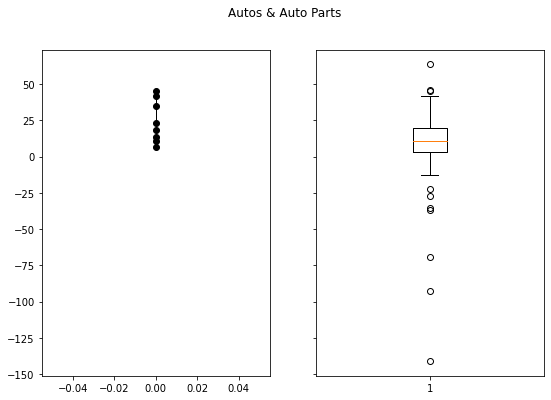

Industrial sector 'Autos & Auto Parts' is comprised of the following 8 company(ies):
['Bayerische Motoren Werke AG', 'Ferrari NV (New)', 'Mercedes-Benz AG', 'Volkswagen AG', 'Ford Motor Co. (DE)', 'Volvo AB', 'Pirelli & C SpA', 'Cie Generale des Etablissements Michelin SCA']
----------
The lower quartile of ROE is: 12.752736
The upper quartile of ROE is: 36.424433
The interquartile range of ROE is: 23.671697
The the median of ROE is: 20.604798 
Values below -22.754809500000007 could be outliers.
Values above 71.93197850000001 could be outliers.
----------
Peer sector comprised of 67 companies
----------
The lower quartile of ROE is: 3.234415
The upper quartile of ROE is: 20.0395745
The interquartile range of ROE is: 16.805159500000002
The the median of ROE is: 10.934151 
Values below -21.973324250000005 could be outliers.
Values above 45.24731375 could be outliers.
----------


<Figure size 432x288 with 0 Axes>

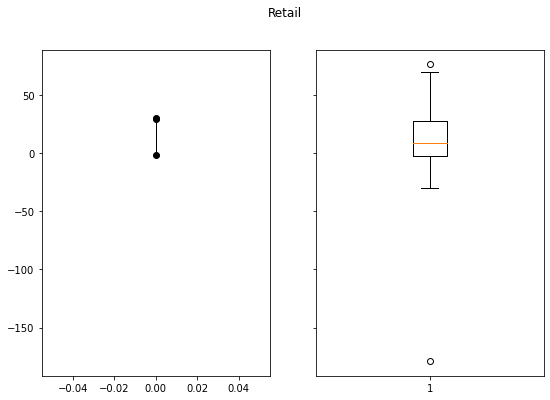

Industrial sector 'Retail' is comprised of the following 3 company(ies):
['Amazon.com Inc', 'Adidas AG', 'JD.com Inc']
----------
The lower quartile of ROE is: 13.504865
The upper quartile of ROE is: 29.546315999999997
The interquartile range of ROE is: 16.041450999999995
The the median of ROE is: 28.80565 
Values below -10.557311499999992 could be outliers.
Values above 53.60849249999999 could be outliers.
----------
Peer sector comprised of 24 companies
----------
The lower quartile of ROE is: -2.34549725
The upper quartile of ROE is: 27.316136
The interquartile range of ROE is: 29.66163325
The the median of ROE is: 8.458802 
Values below -46.83794712500001 could be outliers.
Values above 71.808585875 could be outliers.
----------


<Figure size 432x288 with 0 Axes>

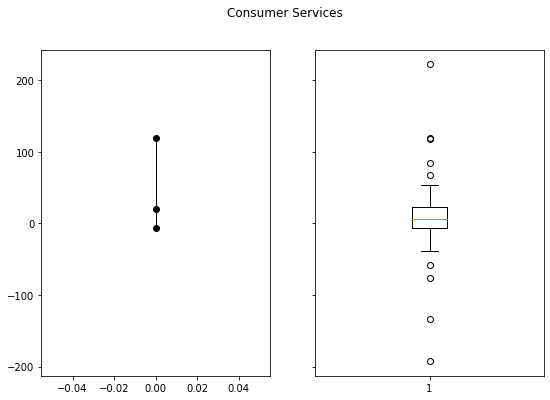

Industrial sector 'Consumer Services' is comprised of the following 3 company(ies):
['Marriott International, Inc.', 'PayPal Holdings Inc', 'Hyatt Hotels Corp']
----------
The lower quartile of ROE is: 6.7093490000000005
The upper quartile of ROE is: 69.585284
The interquartile range of ROE is: 62.875935
The the median of ROE is: 19.973171 
Values below -87.6045535 could be outliers.
Values above 163.89918649999998 could be outliers.
----------
Peer sector comprised of 63 companies
----------
The lower quartile of ROE is: -6.281516
The upper quartile of ROE is: 22.773281
The interquartile range of ROE is: 29.054797
The the median of ROE is: 6.246026 
Values below -49.863711499999994 could be outliers.
Values above 66.3554765 could be outliers.
----------


<Figure size 432x288 with 0 Axes>

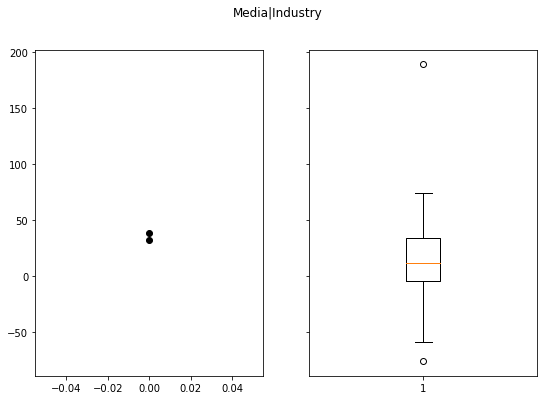

Industrial sector 'Media|Industry' is comprised of the following 2 company(ies):
['Alphabet Inc', 'Netflix Inc']
----------
The lower quartile of ROE is: 33.5565915
The upper quartile of ROE is: 36.5311265
The interquartile range of ROE is: 2.974534999999996
The the median of ROE is: 35.043859 
Values below 29.09478900000001 could be outliers.
Values above 40.99292899999999 could be outliers.
----------
Peer sector comprised of 23 companies
----------
The lower quartile of ROE is: -4.9708775
The upper quartile of ROE is: 33.588816
The interquartile range of ROE is: 38.5596935
The the median of ROE is: 11.838709 
Values below -62.81041775 could be outliers.
Values above 91.42835625000001 could be outliers.
----------


<Figure size 432x288 with 0 Axes>

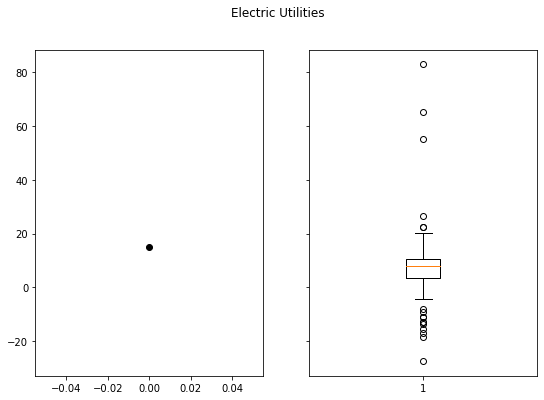

Industrial sector 'Electric Utilities' is comprised of the following 1 company(ies):
['Verbund AG']
----------
The lower quartile of ROE is: 15.044685
The upper quartile of ROE is: 15.044685
The interquartile range of ROE is: 0.0
The the median of ROE is: 15.044685 
Values below 15.044685 could be outliers.
Values above 15.044685 could be outliers.
----------
Peer sector comprised of 81 companies
----------
The lower quartile of ROE is: 3.392093
The upper quartile of ROE is: 10.623457
The interquartile range of ROE is: 7.231364
The the median of ROE is: 8.036192 
Values below -7.454953000000001 could be outliers.
Values above 21.470503 could be outliers.
----------


<Figure size 432x288 with 0 Axes>

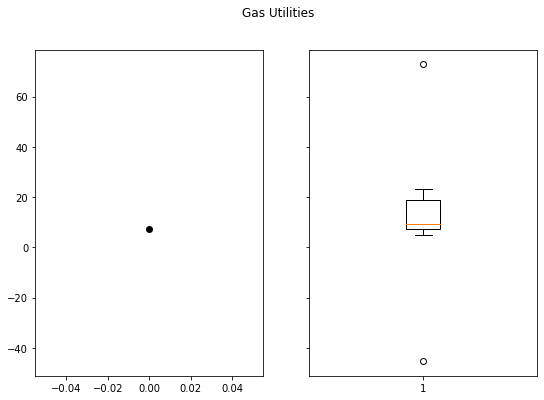

Industrial sector 'Gas Utilities' is comprised of the following 1 company(ies):
['Southwest Gas Holdings, Inc.']
----------
The lower quartile of ROE is: 7.134024
The upper quartile of ROE is: 7.134024
The interquartile range of ROE is: 0.0
The the median of ROE is: 7.134024 
Values below 7.134024 could be outliers.
Values above 7.134024 could be outliers.
----------
Peer sector comprised of 13 companies
----------
The lower quartile of ROE is: 7.134024
The upper quartile of ROE is: 18.925911
The interquartile range of ROE is: 11.791887
The the median of ROE is: 9.211386 
Values below -10.553806499999997 could be outliers.
Values above 36.613741499999996 could be outliers.
----------


<Figure size 432x288 with 0 Axes>

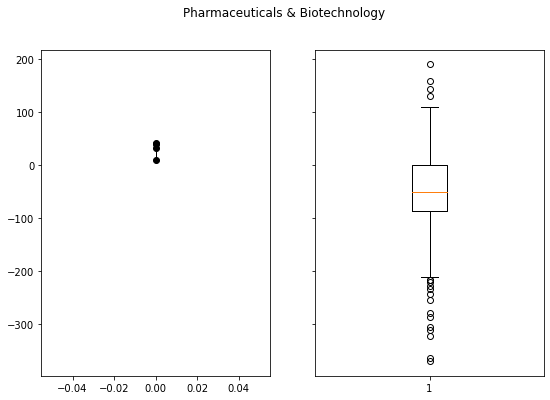

Industrial sector 'Pharmaceuticals & Biotechnology' is comprised of the following 4 company(ies):
['Pfizer Inc', 'Sanofi', 'Merck & Co Inc', 'Novartis AG Basel']
----------
The lower quartile of ROE is: 25.839274000000003
The upper quartile of ROE is: 39.27313625
The interquartile range of ROE is: 13.433862249999997
The the median of ROE is: 34.983253 
Values below 5.6884806250000075 could be outliers.
Values above 59.423929625 could be outliers.
----------
Peer sector comprised of 230 companies
----------
The lower quartile of ROE is: -86.86870124999999
The upper quartile of ROE is: -0.62386275
The interquartile range of ROE is: 86.24483849999999
The the median of ROE is: -50.4151635 
Values below -216.23595899999995 could be outliers.
Values above 128.74339499999996 could be outliers.
----------


<Figure size 432x288 with 0 Axes>

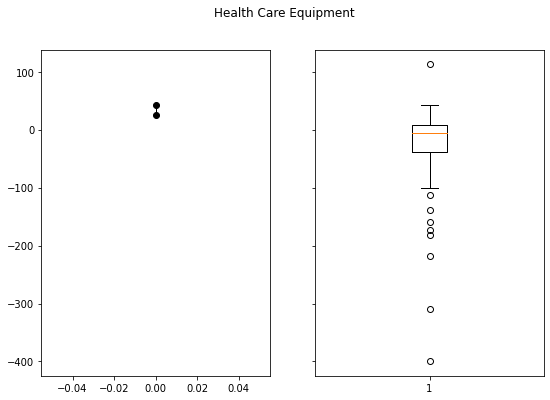

Industrial sector 'Health Care Equipment' is comprised of the following 2 company(ies):
['3M Co', 'Royal Philips NV']
----------
The lower quartile of ROE is: 29.529351750000004
The upper quartile of ROE is: 38.12623525
The interquartile range of ROE is: 8.596883499999997
The the median of ROE is: 33.8277935 
Values below 16.634026500000008 could be outliers.
Values above 51.02156049999999 could be outliers.
----------
Peer sector comprised of 108 companies
----------
The lower quartile of ROE is: -38.907445249999995
The upper quartile of ROE is: 8.8633115
The interquartile range of ROE is: 47.77075675
The the median of ROE is: -5.308547000000001 
Values below -110.56358037499999 could be outliers.
Values above 80.51944662499999 could be outliers.
----------


<Figure size 432x288 with 0 Axes>

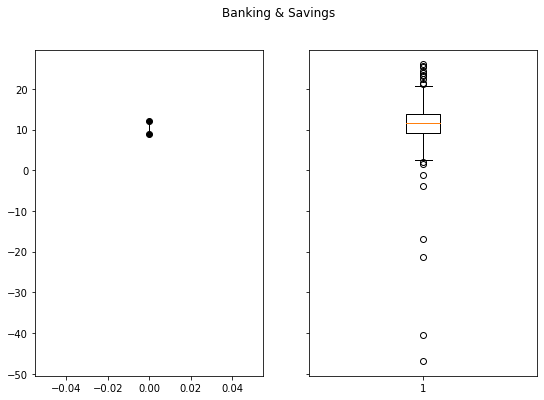

Industrial sector 'Banking & Savings' is comprised of the following 2 company(ies):
['Capital City Bank Group, Inc.', 'DBS Group Holdings Ltd.']
----------
The lower quartile of ROE is: 9.8238325
The upper quartile of ROE is: 11.364821499999998
The interquartile range of ROE is: 1.540988999999998
The the median of ROE is: 10.594327 
Values below 7.512349000000003 could be outliers.
Values above 13.676304999999996 could be outliers.
----------
Peer sector comprised of 339 companies
----------
The lower quartile of ROE is: 9.2349175
The upper quartile of ROE is: 13.930059
The interquartile range of ROE is: 4.6951415
The the median of ROE is: 11.749784 
Values below 2.1922052499999998 could be outliers.
Values above 20.97277125 could be outliers.
----------


<Figure size 432x288 with 0 Axes>

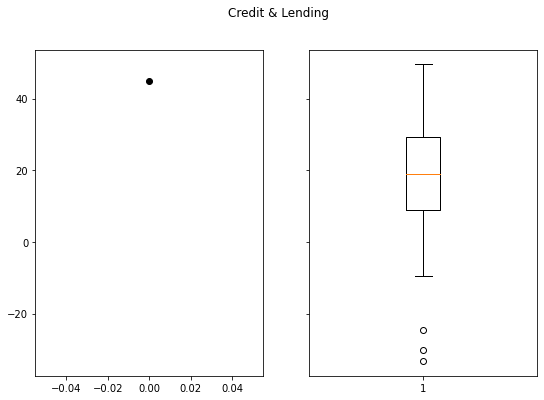

Industrial sector 'Credit & Lending' is comprised of the following 1 company(ies):
['Discover Financial Services']
----------
The lower quartile of ROE is: 44.862506
The upper quartile of ROE is: 44.862506
The interquartile range of ROE is: 0.0
The the median of ROE is: 44.862506 
Values below 44.862506 could be outliers.
Values above 44.862506 could be outliers.
----------
Peer sector comprised of 47 companies
----------
The lower quartile of ROE is: 8.970339
The upper quartile of ROE is: 29.3637565
The interquartile range of ROE is: 20.3934175
The the median of ROE is: 18.965754 
Values below -21.619787250000005 could be outliers.
Values above 59.953882750000005 could be outliers.
----------


<Figure size 432x288 with 0 Axes>

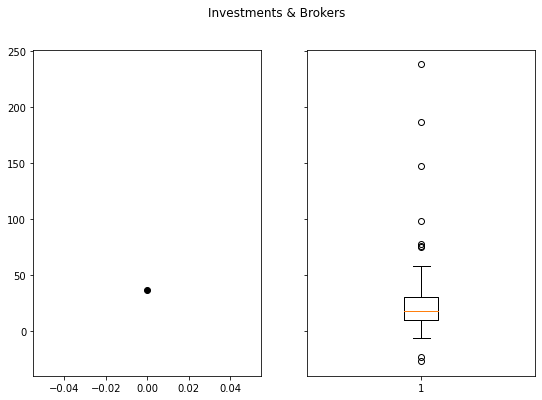

Industrial sector 'Investments & Brokers' is comprised of the following 1 company(ies):
['T Rowe Price Group, Inc.']
----------
The lower quartile of ROE is: 36.855413
The upper quartile of ROE is: 36.855413
The interquartile range of ROE is: 0.0
The the median of ROE is: 36.855413 
Values below 36.855413 could be outliers.
Values above 36.855413 could be outliers.
----------
Peer sector comprised of 76 companies
----------
The lower quartile of ROE is: 9.96455425
The upper quartile of ROE is: 30.47241975
The interquartile range of ROE is: 20.5078655
The the median of ROE is: 17.9479235 
Values below -20.797244 could be outliers.
Values above 61.234218 could be outliers.
----------


<Figure size 432x288 with 0 Axes>

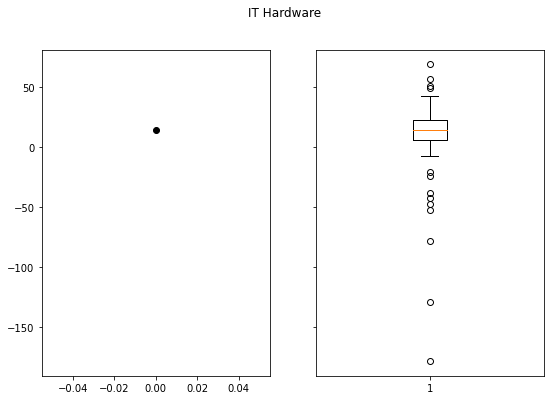

Industrial sector 'IT Hardware' is comprised of the following 1 company(ies):
['Samsung Electronics Co Ltd']
----------
The lower quartile of ROE is: 13.918508
The upper quartile of ROE is: 13.918508
The interquartile range of ROE is: 0.0
The the median of ROE is: 13.918508 
Values below 13.918508 could be outliers.
Values above 13.918508 could be outliers.
----------
Peer sector comprised of 59 companies
----------
The lower quartile of ROE is: 5.902859
The upper quartile of ROE is: 22.341016500000002
The interquartile range of ROE is: 16.438157500000003
The the median of ROE is: 14.340528 
Values below -18.754377250000005 could be outliers.
Values above 46.998252750000006 could be outliers.
----------


<Figure size 432x288 with 0 Axes>

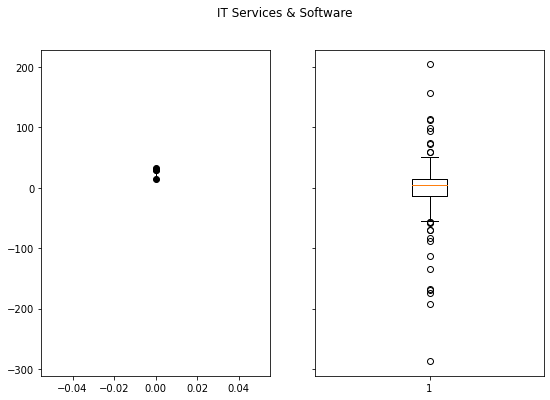

Industrial sector 'IT Services & Software' is comprised of the following 4 company(ies):
['International Business Machines Corp.', 'Dassault Systemes SE', 'Tencent Holdings Ltd.', 'Shopify Inc']
----------
The lower quartile of ROE is: 25.246004749999997
The upper quartile of ROE is: 30.6405455
The interquartile range of ROE is: 5.394540750000004
The the median of ROE is: 29.426061 
Values below 17.15419362499999 could be outliers.
Values above 38.73235662500001 could be outliers.
----------
Peer sector comprised of 199 companies
----------
The lower quartile of ROE is: -13.6723435
The upper quartile of ROE is: 15.0938235
The interquartile range of ROE is: 28.766167
The the median of ROE is: 4.649464 
Values below -56.821594000000005 could be outliers.
Values above 58.243074 could be outliers.
----------


<Figure size 432x288 with 0 Axes>

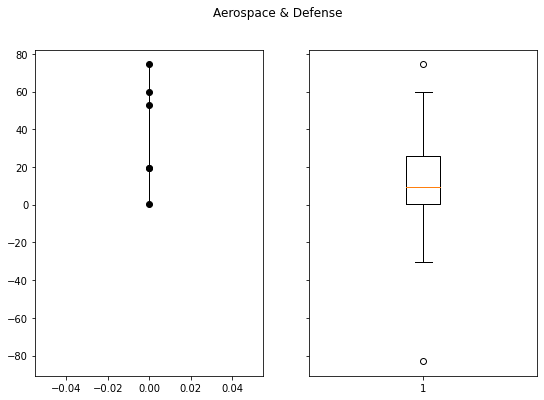

Industrial sector 'Aerospace & Defense' is comprised of the following 6 company(ies):
['Lockheed Martin Corp', 'Airbus SE', 'Safran', 'Northrop Grumman Corp', 'General Dynamics Corp', 'General Dynamics Corp']
----------
The lower quartile of ROE is: 19.560387
The upper quartile of ROE is: 57.9425235
The interquartile range of ROE is: 38.3821365
The the median of ROE is: 36.2587305 
Values below -38.01281775 could be outliers.
Values above 115.51572825 could be outliers.
----------
Peer sector comprised of 23 companies
----------
The lower quartile of ROE is: 0.5700225
The upper quartile of ROE is: 26.106531500000003
The interquartile range of ROE is: 25.536509000000002
The the median of ROE is: 9.24456 
Values below -37.73474100000001 could be outliers.
Values above 64.41129500000001 could be outliers.
----------


<Figure size 432x288 with 0 Axes>

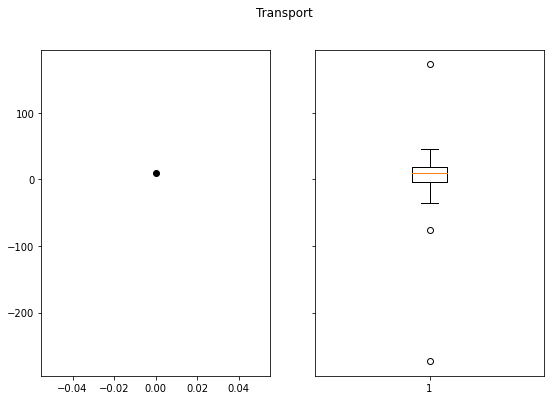

Industrial sector 'Transport' is comprised of the following 1 company(ies):
['Delta Air Lines Inc (DE)']
----------
The lower quartile of ROE is: 10.330197
The upper quartile of ROE is: 10.330197
The interquartile range of ROE is: 0.0
The the median of ROE is: 10.330197 
Values below 10.330197 could be outliers.
Values above 10.330197 could be outliers.
----------
Peer sector comprised of 35 companies
----------
The lower quartile of ROE is: -3.8714635
The upper quartile of ROE is: 19.006314500000002
The interquartile range of ROE is: 22.877778000000003
The the median of ROE is: 10.129601 
Values below -38.1881305 could be outliers.
Values above 53.322981500000004 could be outliers.
----------


<Figure size 432x288 with 0 Axes>

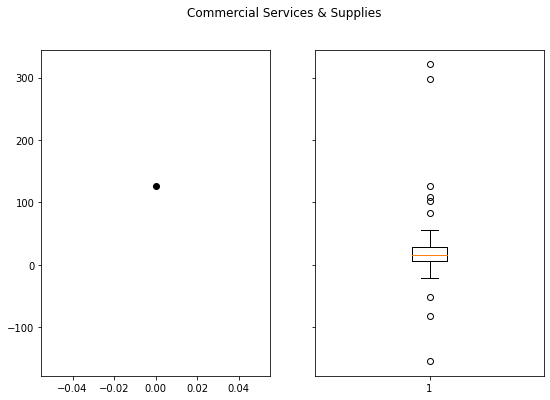

Industrial sector 'Commercial Services & Supplies' is comprised of the following 1 company(ies):
['Mastercard Inc']
----------
The lower quartile of ROE is: 126.789754
The upper quartile of ROE is: 126.789754
The interquartile range of ROE is: 0.0
The the median of ROE is: 126.789754 
Values below 126.789754 could be outliers.
Values above 126.789754 could be outliers.
----------
Peer sector comprised of 98 companies
----------
The lower quartile of ROE is: 5.76515025
The upper quartile of ROE is: 29.25994575
The interquartile range of ROE is: 23.494795500000002
The the median of ROE is: 16.0009595 
Values below -29.477043000000002 could be outliers.
Values above 64.502139 could be outliers.
----------


<Figure size 432x288 with 0 Axes>

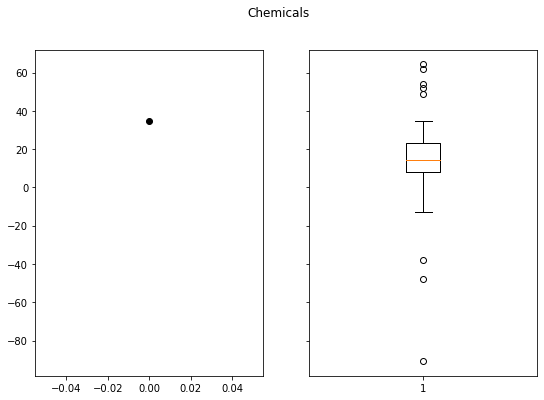

Industrial sector 'Chemicals' is comprised of the following 1 company(ies):
['Wacker Chemie AG Muenchen']
----------
The lower quartile of ROE is: 34.75246
The upper quartile of ROE is: 34.75246
The interquartile range of ROE is: 0.0
The the median of ROE is: 34.75246 
Values below 34.75246 could be outliers.
Values above 34.75246 could be outliers.
----------
Peer sector comprised of 68 companies
----------
The lower quartile of ROE is: 8.268866500000001
The upper quartile of ROE is: 23.097123249999996
The interquartile range of ROE is: 14.828256749999994
The the median of ROE is: 14.0817865 
Values below -13.97351862499999 could be outliers.
Values above 45.33950837499999 could be outliers.
----------


<Figure size 432x288 with 0 Axes>

In [137]:
# Iterate to industrial sectors of interest to compare industry performance vs that of Forbes ranked companies
for index, row in forbes_data_wroes_grouped.iterrows():
    roe_forbes = forbes_data_wroes_df.loc[forbes_data_wroes_df["sector_short"]==index, "ROE"]
    name_list = list(forbes_data_wroes_df.loc[forbes_data_wroes_df["sector_short"]==index, "mergent_name"])

    selected_name = mic_names.loc[mic_names["Code"]==float(index)]
    selected_name_l = list(selected_name["Description"])

    plot_xs = list(roe_forbes)
    plot_ys = [0] * len(roe_forbes)

    roe_ind = industry_data_trimmed_df.loc[industry_data_trimmed_df["sector_short"]==index, "ROE"]
    plot_x = list(roe_ind)
    plot_y = [0] * len(plot_x)

    fig, axs = plt.subplots(1,2, figsize=(9, 6), sharey=True)
    axs[0].plot(plot_ys, plot_xs, marker="o", color="black", linewidth=1)
    axs[1].boxplot(plot_x)
    fig.suptitle(f"{selected_name_l[0]}")
    plt.show()

    print(f"Industrial sector '{selected_name_l[0]}' is comprised of the following {len(plot_xs)} company(ies):")
    print(name_list)
    print("-" *10)

    # Quartiles calculation
    quartiles = roe_forbes.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq

    print(f"The lower quartile of ROE is: {lowerq}")
    print(f"The upper quartile of ROE is: {upperq}")
    print(f"The interquartile range of ROE is: {iqr}")
    print(f"The the median of ROE is: {quartiles[0.5]} ")

    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    print(f"Values below {lower_bound} could be outliers.")
    print(f"Values above {upper_bound} could be outliers.")

    print("-" *10)
    print(f"Peer sector comprised of {len(plot_x)} companies")
    print("-" *10)

    # Quartiles calculation
    quartiles = roe_ind.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq

    print(f"The lower quartile of ROE is: {lowerq}")
    print(f"The upper quartile of ROE is: {upperq}")
    print(f"The interquartile range of ROE is: {iqr}")
    print(f"The the median of ROE is: {quartiles[0.5]} ")

    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    print(f"Values below {lower_bound} could be outliers.")
    print(f"Values above {upper_bound} could be outliers.") 

    print("-" *10)
    try:
        if len(plot_xs) > 2:
            stats.ttest_1samp(plot_xs, mean(plot_x))
    except:
        print('Insufficient data for independent T-test')

    plt.savefig(f'Images/ROE_{index}_{selected_name_l[0]}.png')

<AxesSubplot:title={'center':'ROE'}, xlabel='sector_short'>

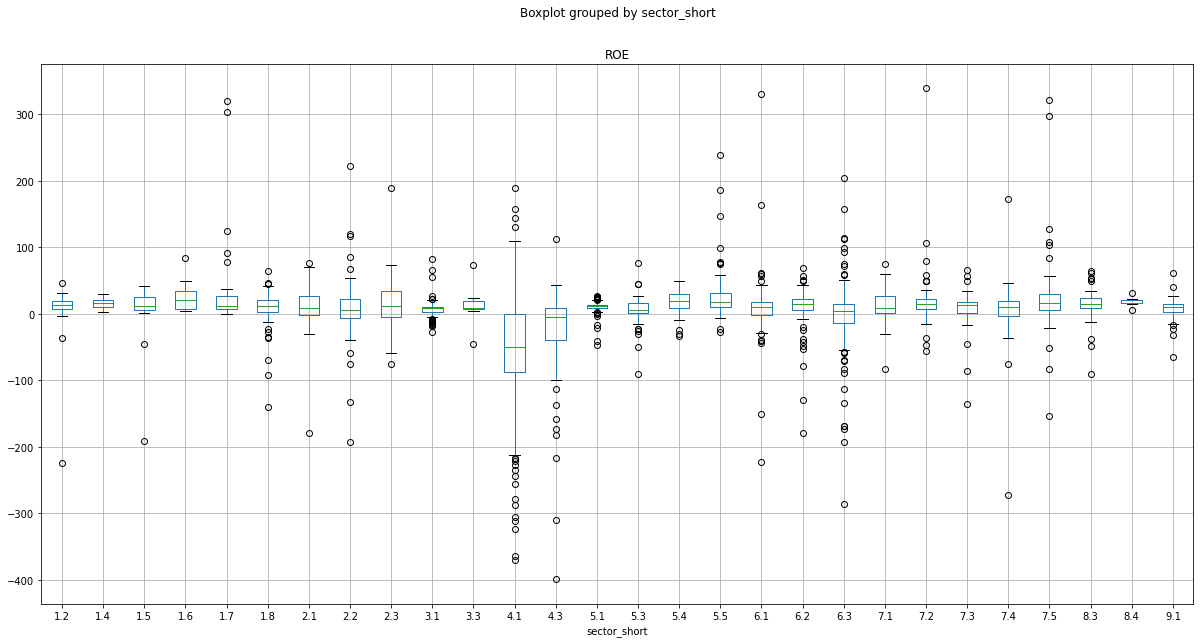

In [136]:
industry_data_trimmed_df.boxplot("ROE", by="sector_short", figsize=(20, 10))